# Voronoi District #

This notebook walks through the process of figuring out how to redistrict the United States using Voronoi Tesselations.

In [32]:
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon as PolygonPatch
from matplotlib import colors as pltcolors
from matplotlib import cm
from shapely.geometry import Point, Polygon, LineString
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 9)

# These are the regions that have no votes in Congress. :(
UNREPRESENTED = ['District of Columbia', 'Puerto Rico']

# Hawaii has 8 main islands but several tiny atolls that extend for a thousand miles.
# This is the area cutoff between the 8 main islands and the tiny atolls.
ATOLL_CUTOFF = 0.005

# Alaska is big!
AL_SCALE = 0.35

# Coordinates for translating Alaska and Hawaii
AL_TRANS_X = 1100000
AL_TRANS_Y = -1300000
HI_TRANS_X = 5200000
HI_TRANS_Y = -1400000

### Creating a plot of the United States ###

Create a basemap object and import the shape files. We need to translate Alaska and Hawaii manually to show them on the map and handle the many tiny islands of Hawaii carefully.

References:

http://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states

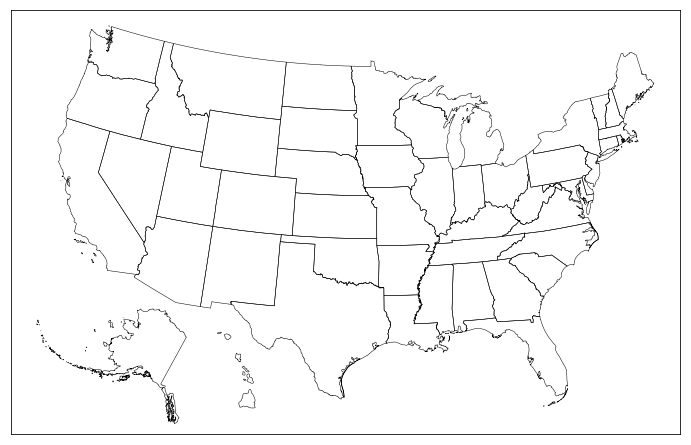

In [3]:
# Build the basemap object
m = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
m.readshapefile('data/st99_d00', name='states', drawbounds=True)

ax = plt.gca()

def translate_alaska_hawaii(m, ax):
    """ Translate Alaska and Hawaii so that they show on the map.
    
    Args:
        m (Basemap): The basemap pre-loaded with state info
        ax (matplotlib.axes): The axes for which to draw Alaska and Hawaii
    """
    for shapedict in m.states_info:
        name = shapedict['NAME']
        # Translate the noncontiguous states:
        if name in ['Alaska', 'Hawaii']:
            seg = m.states[int(shapedict['SHAPENUM'] - 1)]
            # Only include the 8 main islands of Hawaii so that we don't put dots in the western states.
            if name == 'Hawaii' and float(shapedict['AREA']) > ATOLL_CUTOFF:
                seg = list(map(lambda (x,y): (x + HI_TRANS_X, y + HI_TRANS_Y), seg))
            # Alaska is large. Rescale it.
            elif name == 'Alaska':
                seg = list(map(lambda (x,y): (AL_SCALE * x + AL_TRANS_X, AL_SCALE * y + AL_TRANS_Y), seg))
            poly = PolygonPatch(seg, facecolor='white', edgecolor='black', linewidth=.5)
            ax.add_patch(poly)

translate_alaska_hawaii(m, ax)
plt.show()

### Put random points in a state ###

1. Find a bounding box for the state.
2. Generate a random point inside that bounding box.
3. Save the point if it is inside the state.
4. Repeat steps 2 & 3 until the required number of points are found.

Be careful to handle states made of multiple polygons.

This version doesn't take into account population density.

References: 

1. http://ilyasterin.com/blog/2010/05/random-points-in-polygon-generation-algorithm.html
2. http://stackoverflow.com/questions/21612976/point-inside-polygon

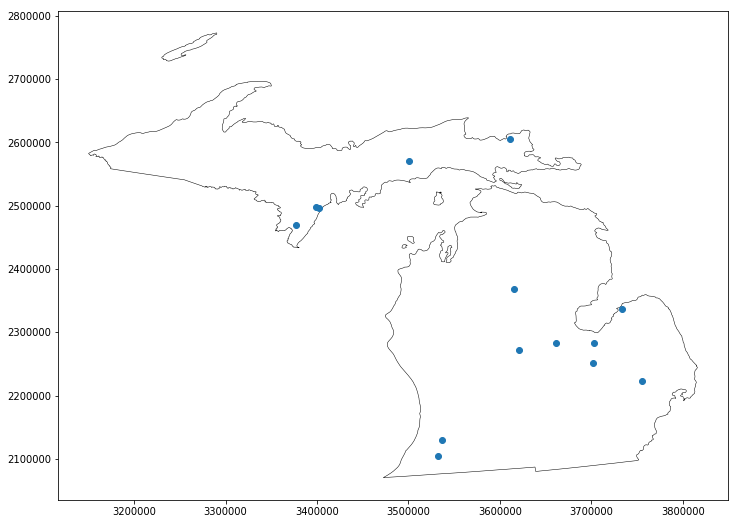

In [4]:
# Test using Michigan because it has 7 chunks.

def get_state(m, name):
    """ Gather all of one state's polygons in case it has many.
    
    Args:
        m (Basemap): The basemap pre-loaded with state info.
        name: (string): The name of the state.
        
    Returns:
        list: list of lists of polys.
    """
    state_polys = []
    for shapedict in m.states_info:
        if shapedict['NAME'] == name:
            poly = np.array(m.states[int(shapedict['SHAPENUM'] - 1)])
            state_polys.append(poly)
    return state_polys


def plot_state(polys, ax):
    """ Add the state polys to the plot.
    
    Args:
        polys (list): list of lists of polys
        ax (matplotlib.axes): The axes for which to draw Alaska and Hawaii
    """
    for poly in polys:
        state_patch = PolygonPatch(poly, facecolor='white', edgecolor='black', linewidth=.5)
        ax.add_patch(state_patch)


def state_points(state_polys, num):
    """ Generate a list of random points inside the state. Handle the case of states
    with non-contiguous chunks.
    
    Args:
        state_polys (list of np.array): list of arrays of 2D points making up the state
        num (int): Number of points to generate
        
    Returns:
        two lists of floats, first is the x coordinates, second
        is the y coordinates.
    """
    points = [[], []]
    
    while len(points[0]) < num:

        # Find bounding box
        state = np.vstack(state_polys)
        swcrnr = (np.min(state[:,0]), np.min(state[:,1]))
        necrnr = (np.max(state[:,0]), np.max(state[:,1]))
        width = necrnr[0] - swcrnr[0]
        height = necrnr[1] - swcrnr[1]

        # Generate random point in bounding box
        x = swcrnr[0] + width * np.random.rand()
        y = swcrnr[1] + height * np.random.rand()

        # Check if it is inside one of the polys
        pt = Point(x, y)
        polys = [Polygon(p) for p in state_polys]
        if any([poly.contains(pt) for poly in polys]):
            points[0].append(x)
            points[1].append(y)
            
    return points

state_polys = get_state(m, 'Michigan')
points = state_points(state_polys, 14)
plot_state(state_polys, plt.gca())
ax.axis('equal')
plt.plot(points[0], points[1], 'o')
plt.show()

### Put points in all states, corresponding to number of districts ###

1. Load the number of districts.
2. Consolidate all the states into lists of polygons.
3. Loop over consolidated states and get the random points.

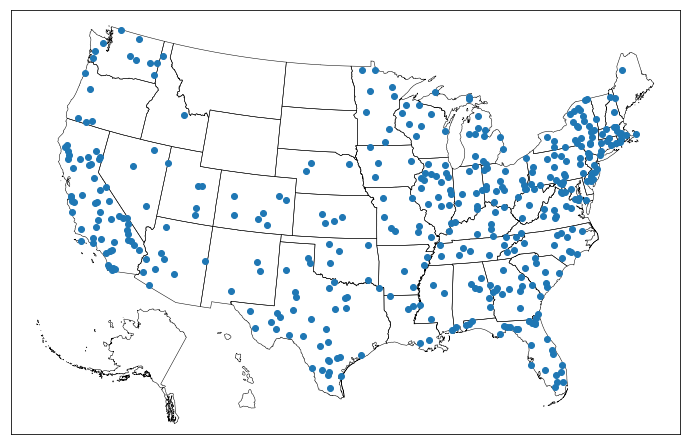

In [5]:
# build a dictionary with number of districts by state name
with open('data/districts_by_state_113th.csv') as h:
    reader = csv.reader(h)
    districts = {k:v for k,v in reader}

m = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
m.readshapefile('data/st99_d00', name='states', drawbounds=True)

def consolidate_states(m):
    """ Some states, like Michigan and Hawaii, are not contiguous. Gather the
    polygons into a list. Skip unrepresented regions.
    
    Args:
        m (Basemap): The basemap pre-loaded with state info.
        
    Returns:
        dict: keyed by state name, values are lists of 2D points.
    """
    state_polys = {}
    for shapedict in m.states_info:
        name = shapedict['NAME']
        # Skip the "states" that are, shamefully, unrepresented.
        if name in UNREPRESENTED:
            continue
        poly = np.array(m.states[int(shapedict['SHAPENUM'] - 1)])
        try:
            state_polys[name].append(poly)
        except KeyError:
            state_polys[name] = [poly]
    return state_polys
        

def us_points(state_polys, districts, points_func=state_points):
    """ Fill U.S. map with random points, distributed in the states by number of districts.
    
    Args:
        state_polys (dict): Keyed by state name, values are lists of 2D points.
        districts (dict): Keyed by state name, values are numbers of districts.
        points_func (callable): Function that populates points by state.
        
    Returns:
        two lists of floats, first is the x coordinates, second
        is the y coordinates.
    """
    points = [[],[]]
    # now loop over the consolidated states
    for name, polys in state_polys.items():
        num_districts = int(districts[name])
        if num_districts > 1:
            spoints = points_func(polys, num_districts)
            points[0] += spoints[0]
            points[1] += spoints[1]
    return points


translate_alaska_hawaii(m, plt.gca())
state_polys = consolidate_states(m)
points = us_points(state_polys, districts)
plt.plot(points[0], points[1], 'o')
plt.show()

### Build Voronoi cells in one state ###

Given random points, build one Congressional district for each point. Find the Voronoi cells and where they intersect the state lines. Michigan is a good test case because it has multiple regions including small islands. 

References:

http://stackoverflow.com/questions/20515554/colorize-voronoi-diagram

In [18]:
# Copied from stack overflow link above. This constructs a complete polygon for each Voronoi region.
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

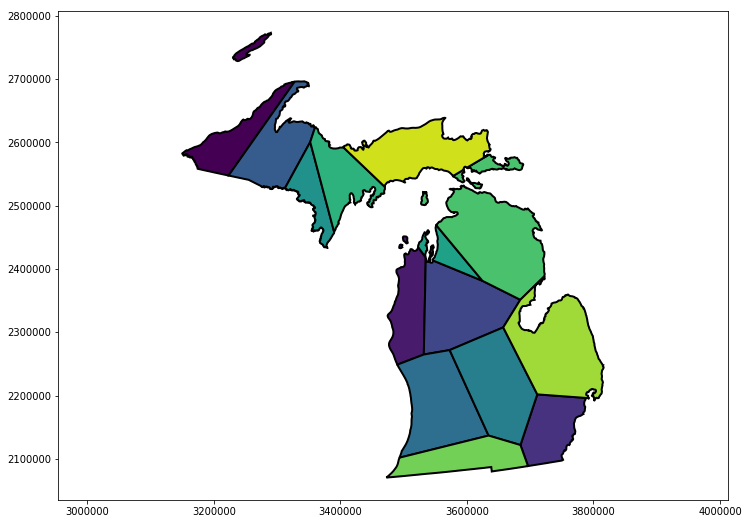

In [75]:
N = 14
state_polys = get_state(m, 'Michigan')
points = state_points(state_polys, N)
vor_points = np.array(points).T
vor = Voronoi(vor_points)
# voronoi_plot_2d(vor)
# ax = plt.gca()
fig, ax = plt.subplots()
plot_state(state_polys, plt.gca())
ax.axis('equal')
state_polys = [Polygon(poly) for poly in state_polys]

district_polys = []

regions, vertices = voronoi_finite_polygons_2d(vor)

# loop over voronoi cells and state polys. build up polygons that represent 
# the districts. districts can be many polygons if the state contains
# many polygons. 
for region in regions:
    dpolys = []
    
    rvertices = [vertices[i] for i in region]
    vpoly = Polygon(rvertices)
    
    for spoly in state_polys:

        # if the entire cell is inside the state, that's a district
        if spoly.contains(vpoly):
            dpolys.append(rvertices)
            break
            
        # if the entire state region is inside the region, add it to dpolys
        if vpoly.contains(spoly):
            dpolys.append(spoly.boundary)

        # Otherwise, we need to calculate an intersection
        else:
            if vpoly.intersects(spoly):
                ixn = vpoly.intersection(spoly)
                if isinstance(ixn, Polygon):
                    dpolys.append(ixn.boundary.coords)
                else:
                    for piece in ixn.geoms:
                        dpolys.append(piece.boundary.coords)

    district_polys.append(dpolys)
            
colors = pltcolors.Normalize(0, N)

for i, polys in enumerate(district_polys):
    color = cm.viridis(colors(i))
    for poly in polys:
        district_patch = PolygonPatch(poly, facecolor=color, edgecolor='black', linewidth=2)
        ax.add_patch(district_patch)

plt.show()